In [1]:
import torch
import pypose as pp
import numpy as np
import pandas as pd

from scipy.spatial.transform import Rotation as R

from utile import read_files, plot_traj

import os
from tqdm import tqdm
import random
random.seed(0)

import matplotlib.pyplot as plt

/home/pierre/anaconda3/envs/pypose/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "./test_data_clean/2csv/run0.csv"
df = pd.read_csv(path)

In [4]:
pos = df.loc[:, ['x', 'y', 'z']].to_numpy()
euler = df.loc[:, ['roll', 'pitch', 'yaw']].to_numpy()
quat = df.loc[:, ['qx', 'qy', 'qz', 'qw']].to_numpy()
rot_vec = df.loc[:, ['rv0', 'rv1', 'rv2']].to_numpy()
rot_mat = df.loc[:, ['r00', 'r01', 'r02',
                     'r10', 'r11', 'r12',
                     'r20', 'r21', 'r22']].to_numpy().reshape((-1, 3, 3))
I_vel = df.loc[:, ['Iu', 'Iv', 'Iw', 'Ip', 'Iq', 'Ir']].to_numpy()
B_vel = df.loc[:, ['Bu', 'Bv', 'Bw', 'Bp', 'Bq', 'Br']].to_numpy()

gt_traj = np.concatenate([pos, euler], axis=-1)

In [5]:
def to_euler(x):
    pose = x.data.numpy()
    p = pose[0:3]
    q = pose[3:]
    r = R.from_quat(q)
    e = r.as_euler('xyz')
    return np.concatenate([p, e])

## Init SE3 group member from first state

In [6]:
dt = 0.1
x_init = pp.SE3(np.concatenate([pos[0], quat[0]]))

## Left $\oplus$

In [7]:
x = x_init
left_traj = np.zeros(shape=(gt_traj.shape[0], 6))
left_traj[0] = to_euler(x)

for i, v in enumerate(I_vel[:-1]):
    x_next = pp.se3(v*dt).Exp() * x
    left_traj[i+1] = to_euler(x_next)
    x = x_next

## Right $\oplus$

In [8]:
x = x_init
right_traj = np.zeros(shape=(gt_traj.shape[0], 6))
right_traj[0] = to_euler(x)

for i, v in enumerate(B_vel[:-1]):
    x_next = x * pp.se3(v*dt).Exp()
    right_traj[i+1] = to_euler(x_next)
    x = x_next

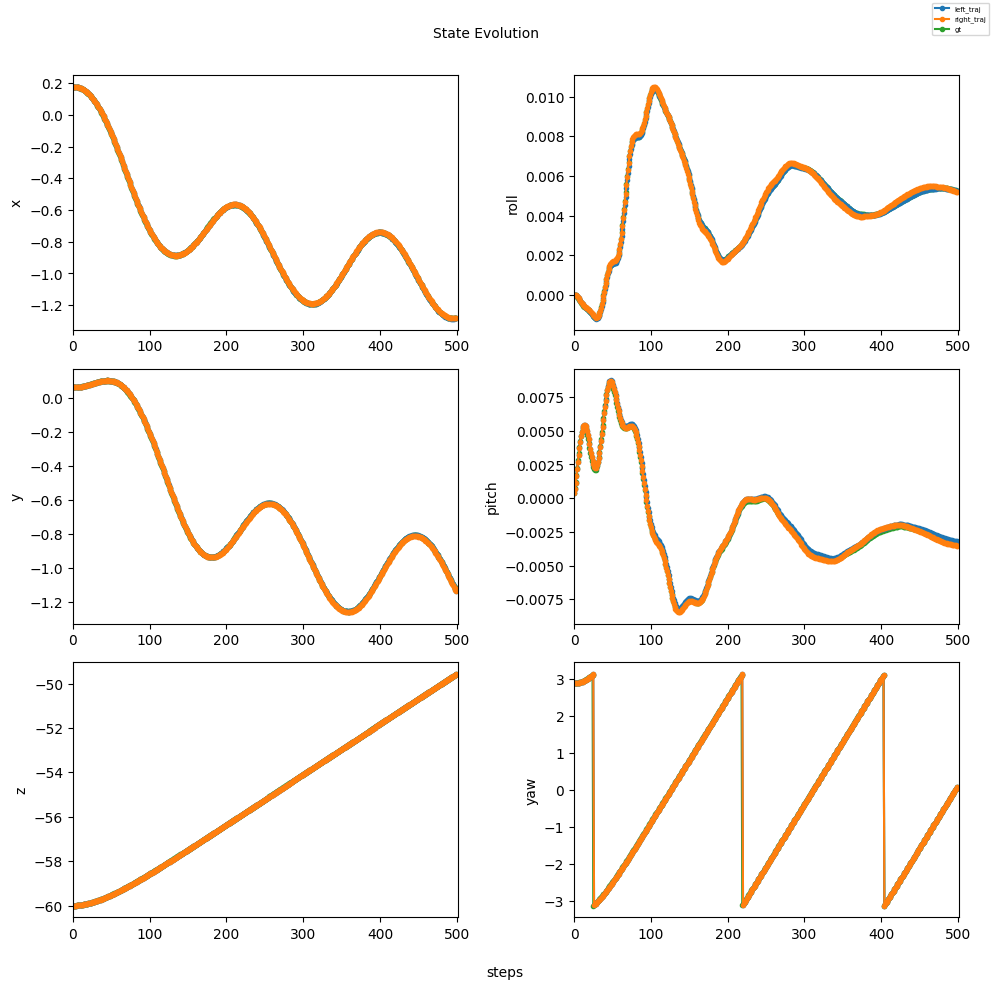

In [9]:
e_cols = {'x': 0, 'y': 1, 'z': 2, 'roll': 3, 'pitch': 4, 'yaw': 5}
plot_traj({"left_traj": left_traj, "right_traj": right_traj, "gt": gt_traj}, e_cols, 500, True, save=True);

In [10]:
# DATASET FOR 3D DATA
class DatasetList3D(torch.utils.data.Dataset):
    def __init__(self, data_list, steps=1, frame="Body"):
        super(DatasetList3D, self).__init__()
        self.data_list = data_list
        self.s = steps
        self.pos = ['x', 'y', "z"]
        self.rot = ['r00', 'r01', 'r02',
                    'r10', 'r11', 'r12',
                    'r20', 'r21', 'r22']
        self.lin_vel = ['Bu', 'Bv', 'Bw']
        self.ang_vel = ['Bp', 'Bq', 'Br']
        self.x_labels = self.pos + self.rot + self.lin_vel + self.ang_vel
        if frame == "Body":
            prefix = "B"
        elif frame == "Inertial":
            prefix = "I"
        self.y_labels = [f'{prefix}du', f'{prefix}dv', f'{prefix}dw', f'{prefix}dp', f'{prefix}dq', f'{prefix}dr']
        self.u_labels = ['Fx', 'Fy', 'Fz', 'Tx', 'Ty', 'Tz']

        self.samples = [traj.shape[0] - self.s for traj in data_list]
        self.len = sum(self.samples)
        self.bins = self.create_bins()

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        # get the trajectory index of the current query
        i = (np.digitize([idx], self.bins)-1)[0]
        traj = self.data_list[i]
        j = idx - self.bins[i]
        sub_frame = traj.iloc[j:j+self.s+1]
        x = sub_frame[self.x_labels].to_numpy()
        x = x[:1]

        u = sub_frame[self.u_labels].to_numpy()
        u = u[:self.s]

        y = sub_frame[self.y_labels].to_numpy()
        y = y[1:self.s+1]
        return x, u, y

    @property
    def nb_trajs(self):
        return len(self.data_list)
    
    def get_traj(self, idx):
        if idx >= self.nb_trajs:
            raise IndexError
        return self.data_list[idx][self.x_labels].to_numpy()
    
    def create_bins(self):
        bins = [0]
        cummul = 0
        for s in self.samples:
            cummul += s
            bins.append(cummul)
        return bins

    def get_trajs(self):
        traj_list = []
        dv_traj_list = []
        action_seq_list = []
        for data in self.data_list:
            traj = data[self.x_labels].to_numpy()
            traj_list.append(traj)

            dv_traj = data[self.y_labels].to_numpy()
            dv_traj_list.append(dv_traj)

            action_seq = data[self.u_labels].to_numpy()
            action_seq_list.append(action_seq)
        return traj_list, dv_traj_list, action_seq_list


In [11]:
data_dir = "test_data_clean/csv/"
dir_name = os.path.basename(data_dir)
files = [f for f in os.listdir(data_dir) if os.path.isfile(os.path.join(data_dir, f))]
random.shuffle(files)

# split train and val in 70-30 ration
train_size = int(0.7*len(files))

train_files = files[:train_size]
val_files = files[train_size:]

print("Data size:  ", len(files))
print("Train size: ", len(train_files))
print("Val size:   ", len(val_files))

dfs_train = read_files(data_dir, train_files, "train")
dfs_val = read_files(data_dir, val_files, "val")

Data size:   9
Train size:  6
Val size:    3


Dir val: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 119.76it/s]


In [12]:
dataset_train = DatasetList3D(dfs_train, steps=10)
dataset_val = DatasetList3D(dfs_val, steps=10)

(x, u, y) = dataset_train[0]
print("x: ", x.shape)
print("u: ", u.shape)
print("y: ", y.shape)

x:  (1, 18)
u:  (10, 6)
y:  (10, 6)


(10, 59)
x:  (1, 18)
u:  (10, 6)
y:  (9, 6)
(10, 59)
x:  (1, 18)
u:  (10, 6)
y:  (9, 6)
(10, 59)
x:  (1, 18)
u:  (10, 6)
y:  (9, 6)


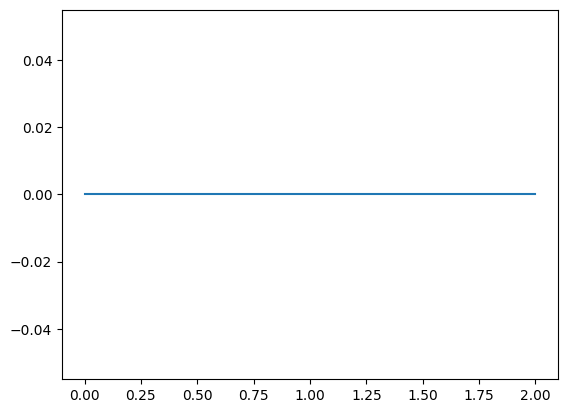

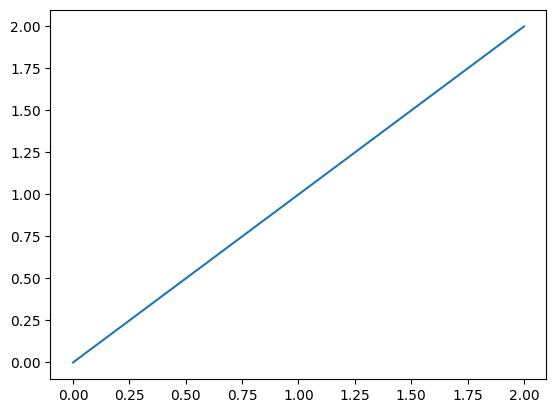

In [13]:
foo = []
bar = []
steps = 10
for idx in range(3):
    i = (np.digitize([idx], dataset_train.bins)-1)[0]
    traj = dataset_train.data_list[i]
    j = idx - dataset_train.bins[i]
    foo.append(i)
    bar.append(j)
    sub_frame = traj.iloc[j:j+steps]
    x = sub_frame[dataset_train.x_labels].to_numpy()
    x = x[:1]
    
    u = sub_frame[dataset_train.u_labels].to_numpy()
    u = u[:steps]

    y = sub_frame[dataset_train.y_labels].to_numpy()
    y = y[1:steps]

    print(sub_frame.shape)
    print("x: ", x.shape)
    print("u: ", u.shape)
    print("y: ", y.shape)


plt.figure()
plt.plot(np.array(foo))
plt.figure()
plt.plot(np.array(bar))


In [49]:
k = 2
tau = 1
in_size = 21
hid_size = 1
num_layers = 5

rnn = torch.nn.RNN(
    input_size=in_size,
    hidden_size=hid_size,
    num_layers=num_layers,
    bias=False,
    batch_first=True,
    nonlinearity="relu")

dummy = torch.rand(size=(k, tau, in_size))
h0 = torch.zeros(size=(num_layers, k, hid_size))

print("Input:", dummy)
print(dummy.shape)

print("h0:", h0)
print(h0.shape)

out, h = rnn(dummy, h0)

print("Out:", out)
print(out.shape)

print("h:", h)
print(h.shape)


Input: tensor([[[0.1795, 0.4035, 0.2182, 0.3705, 0.8113, 0.8532, 0.1328, 0.0515,
          0.9786, 0.6533, 0.9555, 0.5733, 0.9381, 0.4944, 0.2994, 0.7590,
          0.2189, 0.3625, 0.1771, 0.7019, 0.2702]],

        [[0.7146, 0.9372, 0.4675, 0.2975, 0.3508, 0.3717, 0.4231, 0.2304,
          0.6780, 0.4878, 0.4376, 0.7990, 0.2130, 0.4567, 0.8252, 0.9050,
          0.4458, 0.8315, 0.9916, 0.1233, 0.5356]]])
torch.Size([2, 1, 21])
h0: tensor([[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]])
torch.Size([5, 2, 1])
Out: tensor([[[0.]],

        [[0.]]], grad_fn=<TransposeBackward1>)
torch.Size([2, 1, 1])
h: tensor([[[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]],

        [[0.],
         [0.]]], grad_fn=<StackBackward0>)
torch.Size([5, 2, 1])


In [37]:
from RNN_AUV3D import AUVRNNDeltaV

In [38]:
dv_pred = AUVRNNDeltaV()

input_size:  21
rnn_hidden_size:  1
rnn_layers:  5
rnn_bias:  False
nonlinearity:  relu


In [39]:
dv_pred.rnn(dummy)

(tensor([[[0.]],
 
         [[0.]]], grad_fn=<TransposeBackward1>),
 tensor([[[0.],
          [0.]],
 
         [[0.],
          [0.]],
 
         [[0.],
          [0.]],
 
         [[0.],
          [0.]],
 
         [[0.],
          [0.]]], grad_fn=<StackBackward0>))

In [41]:
print(out)

dv_pred.fc(out)

tensor([[[0.8672]],

        [[0.8669]]], grad_fn=<TransposeBackward1>)


tensor([[[-0.0422,  0.0771, -0.0779, -0.0750,  0.0970, -0.1090]],

        [[-0.0422,  0.0770, -0.0778, -0.0749,  0.0970, -0.1089]]],
       grad_fn=<UnsafeViewBackward0>)